В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.

Ответьте на 2 вопроса:

- Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
- Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

Как будет формироваться оценка по тесту:
- Код - лаконичный, не захламленный, понятный
- Визуализации, есть или нет, но не стоит захламлять отчет бесполезными картинками, чтобы показать что вы просто умеете, включите голову и подумайте, где лучше показать в исследовании график.
- Правильность вывода (особенно во второй части задания).

In [32]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-whitegrid')
font = {'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)

Загрузим предоставленный датасет. Посмотрим, что внутри за данные.

In [33]:
df = pd.read_csv(r'ab_test_ensembles.csv')
df.head(10)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user
5,426f77eb-8739-43b6-999c-aecd14d9f346,2022-05-10 15:20:49.083499,control,standard,0,United Kingdom,42-49,registered_user
6,aa9d93c5-a18f-444a-a522-7e7145835362,2022-05-19 03:26:46.940749,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,registered_user
7,de214e30-9b8d-44cf-87b1-16917f3e1c89,2022-05-17 01:48:29.539573,control,standard,0,United Kingdom,18-25,registered_user
8,070f398e-e6bf-43e7-88bb-37eff2cb9212,2022-05-04 17:58:08.979471,treatment,svm_ensemble_v_1_22,1,United Kingdom,18-25,new_user
9,9cff0b7e-d42b-4508-9fbe-a4e74f7f29c5,2022-05-15 18:11:06.610965,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,new_user


Сначала проверим, что датасет "чистый": нет нуевых и пропущенных значений. Как видим ниже общее число записей по датасету совпадает с числом ненулевых записей по каждому из столбцов, значит все ОК.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


Поскольку в задании указано использовать для теста весь датасет, стоит убедиться, что контрольная и тестовая группы представлены в одинаковом количестве и обе видят новую и старую страницы сайта. Как видим ниже - это приблизительно так и есть.

In [35]:
df['group'].value_counts(ascending=False)

treatment    147276
control      147202
Name: group, dtype: int64

In [36]:
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


Как в примере, проверим записи на дубли. Убедимся, что нам повезло и дублей в датасете нет. 🙂

In [37]:
sessions = df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


In [38]:
conversion_rates = df.groupby('group')['converted']

std_proportion = lambda x: np.std(x, ddof=0)

se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.120399,0.325428,0.000848
treatment,0.118920,0.323694,0.000843


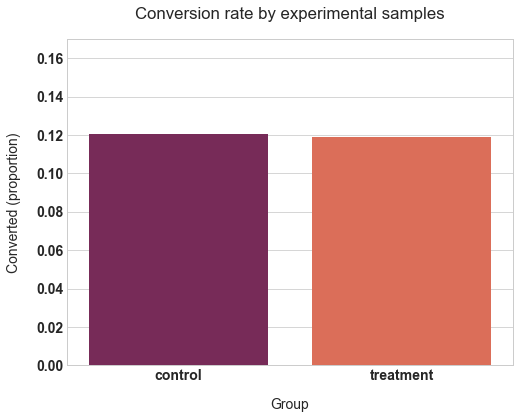

In [39]:
plt.figure(figsize=(8,6));
sns.barplot(x=df['group'], y=df['converted'], ci=False, palette="rocket");
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

In [40]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = df[df['group'] == 'control']['converted']
treatment_results = df[df['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.24
p-value: 0.216
CI 95% for control group: [0.119, 0.122]
CI 95% for treatment group: [0.117, 0.121]


Расчитанное р-значение 0.216 получилось выше принятой альфы в 0.05, следовательно отклонить нулевую гипотезу мы не можем. Доверительный интервал для новых пользователей в испытуемой группе 0.117-0.122, что близко к baseline значению и не достает до целевых 15%.

In [41]:
conversion_rates = df.groupby(['user_type', 'group'])['converted']
std_proportion = lambda x: np.std(x, ddof=0)
se_proportion = lambda x: stats.sem(x, ddof=0)
conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

CR mean    CR std     CR se
user_type       group                                  
new_user        control    0.120746  0.325832  0.001200
                treatment  0.117557  0.322082  0.001188
registered_user control    0.120051  0.325021  0.001199
                treatment  0.120277  0.325285  0.001197

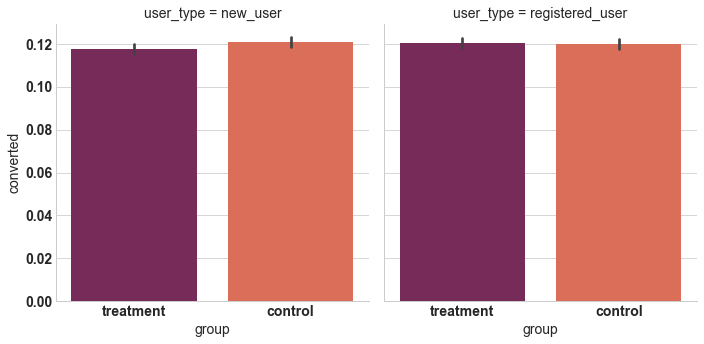

In [42]:
g = sns.FacetGrid(df.sort_values(by='user_type'), col='user_type', col_wrap=2, height=5)
g.map(sns.barplot, 'group', 'converted', order=['treatment', 'control'], palette='rocket');

In [43]:
user_types = df.user_type.unique()
user_types.sort()
columns=['user_type', 
         'Z-statistic', 
         'p-value', 
         'CI 95% for control group, lower', 
         'CI 95% for control group, upper',
         'CI 95% for treatment group, lower',
         'CI 95% for treatment group, upper']

In [44]:
result = []
for user_type in user_types:
    control_results = df[(df['group'] == 'control')&(df['user_type'] == user_type)]['converted']
    treatment_results = df[(df['group'] == 'treatment')&(df['user_type'] == user_type)]['converted']

    n_con = control_results.count()
    n_treat = treatment_results.count()
    successes = [control_results.sum(), treatment_results.sum()]
    nobs = [n_con, n_treat]

    z_stat, pval = proportions_ztest(successes, nobs=nobs)
    (lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)
    result.append([user_type, z_stat, pval, lower_con, upper_con, lower_treat, upper_treat])

result_df = pd.DataFrame(result, columns=columns)
result_df

,user_type,Z-statistic,p-value,"CI 95% for control group, lower","CI 95% for control group, upper","CI 95% for treatment group, lower","CI 95% for treatment group, upper"
0,new_user,1.888646,0.058939,0.118394,0.123097,0.115228,0.119885
1,registered_user,-0.133246,0.893999,0.117701,0.122402,0.117930,0.122624


Р-значение для группы пользователей new_user близко к принятой альфе 0.05, но все же ее превышает. Таким образом даже для категории новых пользователей отклонить нулевую гипотезу о том, что значимого изменения конверсии нет, мы не можем. 
Доверительный интервал для новых пользователей в испытуемой группе 0.115-0.12, что также близко к baseline значению и не достает до целевых 15%.

Я не сразу заметила, по каким группам надо считать и посчитала не по тем, но лишним не будет. Поэтому оставлю свои расчеты ниже.

In [45]:
conversion_rates = df.groupby(['age_group', 'group'])['converted']
std_proportion = lambda x: np.std(x, ddof=0)
se_proportion = lambda x: stats.sem(x, ddof=0)
conversion_rates = conversion_rates.agg([np.mean, std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

CR mean    CR std     CR se
age_group group                                  
18-25     control    0.118006  0.322615  0.002065
          treatment  0.118509  0.323210  0.002071
26-33     control    0.121296  0.326471  0.002079
          treatment  0.120636  0.325703  0.002076
34-41     control    0.119790  0.324715  0.002082
          treatment  0.114868  0.318863  0.002034
42-49     control    0.121329  0.326509  0.002090
          treatment  0.117866  0.322450  0.002051
50-57     control    0.121575  0.326794  0.002085
          treatment  0.119948  0.324901  0.002069
58+       control    0.120382  0.325408  0.002065
          treatment  0.121711  0.326952  0.002095

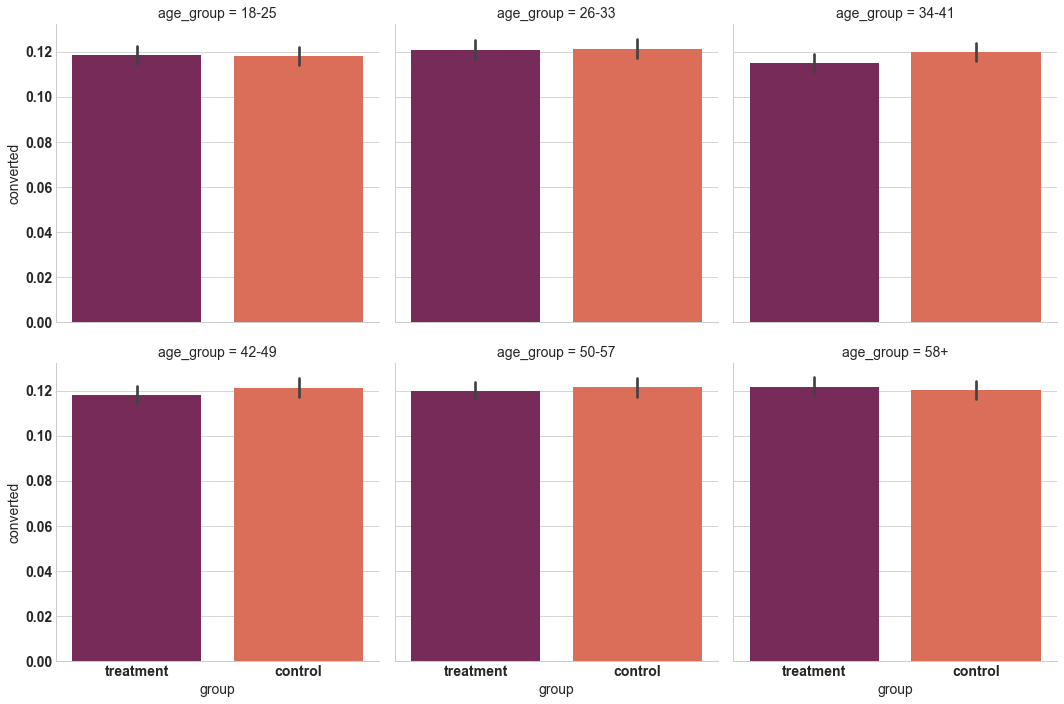

In [46]:
g = sns.FacetGrid(df.sort_values(by='age_group'), col='age_group', col_wrap=3, height=5)
g.map(sns.barplot, 'group', 'converted', order=['treatment', 'control'], palette='rocket');

По графику выше видим, что распределение по группам treatment и control практически не отличаются ни в одной из возграстных групп.

In [47]:
age_groups = df.age_group.unique()
age_groups.sort()
columns=['age_group', 
         'Z-statistic', 
         'p-value', 
         'CI 95% for control group, lower', 
         'CI 95% for control group, upper',
         'CI 95% for treatment group, lower',
         'CI 95% for treatment group, upper']

In [48]:
result = []
for age_group in age_groups:
    control_results = df[(df['group'] == 'control')&(df['age_group'] == age_group)]['converted']
    treatment_results = df[(df['group'] == 'treatment')&(df['age_group'] == age_group)]['converted']

    n_con = control_results.count()
    n_treat = treatment_results.count()
    successes = [control_results.sum(), treatment_results.sum()]
    nobs = [n_con, n_treat]

    z_stat, pval = proportions_ztest(successes, nobs=nobs)
    (lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)
    result.append([age_group, z_stat, pval, lower_con, upper_con, lower_treat, upper_treat])

result_df = pd.DataFrame(result, columns=columns)
result_df

,age_group,Z-statistic,p-value,"CI 95% for control group, lower","CI 95% for control group, upper","CI 95% for treatment group, lower","CI 95% for treatment group, upper"
0,18-25,-0.172019,0.863422,0.113959,0.122053,0.114450,0.122568
1,26-33,0.224619,0.822276,0.117222,0.125370,0.116566,0.124706
2,34-41,1.690952,0.090846,0.115709,0.123870,0.110882,0.118855
3,42-49,1.182540,0.236991,0.117233,0.125425,0.113845,0.121887
4,50-57,0.553844,0.579685,0.117488,0.125662,0.115894,0.124002
5,58+,-0.451782,0.651426,0.116334,0.124430,0.117605,0.125817


Для всех возрастных групп p-значение получилось значительно выше принятой альфы в 0.05, следовательно отклонить нулевую гипотезу мы не можем ни для одной из групп. Но стоит заметить, что для возрастной группы 34-41 p-значение самое наименьшее, возможно на эту группу изменения сайта оказывают наибольшее влияние. Но все равно по итогу эксперимента мы понимаем, что статистически значимых изменений уровня конверсии изменения сайта не принесли ни для одной из групп. 

Доверительные интервалы для каждой из групп колеблются в пределах 0.114-0.126, что близко к текущему значению и все еще не дотягивает до целевого в 15%. Это означает, что с высокой долей вероятности при смене дизайна сайта доля конверсии существенно не изменится ни в одной возрастной группе.